In [1]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score ,silhouette_samples

from IPython.display import Image,display
from IPython.core.display import HTML
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
precess = pd.read_csv("/Users/unixking/Desktop/머신러닝/recommend/Preprocessed_data.csv")

In [3]:
idx = precess[precess['Category'] == '9'].index
precess.drop(idx , inplace=True) ###카테고리에 9가 있으면 드랍한다.

In [4]:
books = pd.read_csv("/Users/unixking/Desktop/머신러닝/recommend/BX_Books.csv", sep=';', encoding="latin-1", error_bad_lines=False)
users = pd.read_csv("/Users/unixking/Desktop/머신러닝/recommend/BX-Users.csv", sep=';', encoding="latin-1", error_bad_lines=False)
ratings = pd.read_csv("/Users/unixking/Desktop/머신러닝/recommend/BX-Book-Ratings.csv", sep=';', encoding="latin-1", error_bad_lines=False)

In [5]:
precess["Category"] = precess["Category"].str.replace('[', '')
precess["Category"] = precess["Category"].str.replace(']', '')
precess["Category"] = precess["Category"].str.replace('\'', '')
precess["Category"] = precess["Category"].str.replace('\"', '') #카테고리칼럼에 쓸데없는 특수문자는 제거


<ipython-input-5-8e00885fb63b>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  precess["Category"] = precess["Category"].str.replace('[', '')
<ipython-input-5-8e00885fb63b>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  precess["Category"] = precess["Category"].str.replace(']', '')


In [6]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [7]:
df = precess
df = df[:100000]

#데이터셋을 나눔

In [8]:
df.columns

df.Category


0         Social Science
1              Actresses
2              Actresses
3              Actresses
4              Actresses
               ...      
152829           Fiction
152830           Fiction
152831           Fiction
152832           Fiction
152833           Fiction
Name: Category, Length: 100000, dtype: object

In [9]:
df[df['rating']> 5].shape #rating이 5이상인 데이터 갯수 확인

(35644, 19)

In [10]:
df1 = df[df['rating']>5].drop_duplicates() #rating이 5이상인 데이터가 중복된것들이 없게 제거

In [11]:
df1["Category"].nunique() #고유값들의 객수 확인

241

In [12]:
crosstab = pd.crosstab(df1['user_id'],df['Category']).astype('bool') #boolean의 형식으로 이를 교차표로서 계산한다.

In [13]:
freq_item = apriori(crosstab,min_support=0.0001,use_colnames=True) #apriori라이브러리를 불러와 지지가 0.0001이상인것들만불러온다,

In [14]:
rules = association_rules(freq_item, metric = "lift", min_threshold = 0.05) #이를 다시 연관분석하여 향상도 threshold가 0.05이상인 것들로 만들어준다.

In [15]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])

rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])

In [16]:
def search_apriori(df1, title):
    string = df1[df1["book_title"] == title]["Category"].iloc[0]
    search_df = rules[rules['antecedents'].str.lower()== string.lower()]
    search_df.sort_values(by='lift', ascending=False)
    search_df = search_df.drop_duplicates()
    arr = search_df[:10]['consequents'].to_list()
    result = []
    for value in arr:
        if value not in result:
            result.append(value)
    recom = []
    for i in result:
        a = df1[df1["Category"] == i]["book_title"].iloc[0]
        recom.append(a)
        
    return recom

In [17]:
recomended = df1


In [18]:
search_apriori(recomended, 'Harry Potter and the Order of the Phoenix (Book 5)')

['A Case of Need',
 'The Secret Diary of Adrian Mole Aged 13 3/4',
 'The Scarlet Letter',
 'The Street Lawyer',
 'October Sky: A Memoir',
 'In Love & Trouble: Stories of Black Women',
 'A Lesson Before Dying (Vintage Contemporaries (Paperback))',
 'A Cold Day for Murder',
 'Tree Grows In Brooklyn',
 'The Mosquito Coast']

In [19]:
search_apriori(recomended, 'Divine Secrets of the Ya-Ya Sisterhood: A Novel')

['A Case of Need',
 'Clara Callan',
 'The Secret Diary of Adrian Mole Aged 13 3/4',
 'Me and My Little Brain',
 'The Scarlet Letter',
 'The Mighty',
 'The Street Lawyer',
 'October Sky: A Memoir']

In [20]:
search_apriori(recomended, 'Harry Potter and the Goblet of Fire (Book 4)')

['A Case of Need',
 'The Secret Diary of Adrian Mole Aged 13 3/4',
 'The Scarlet Letter',
 'The Street Lawyer',
 'October Sky: A Memoir',
 'In Love & Trouble: Stories of Black Women',
 'A Lesson Before Dying (Vintage Contemporaries (Paperback))',
 'A Cold Day for Murder',
 'Tree Grows In Brooklyn',
 'The Mosquito Coast']

In [21]:
mean_users_rating = ratings.groupby('User-ID')['Book-Rating'].mean()
users_rating = ratings.set_index('User-ID')
users_rating['mean-rating'] = mean_users_rating
users_rating.reset_index(inplace = True)
users_rating = users_rating[users_rating['Book-Rating'] > users_rating['mean-rating']]
users_rating['is_fav'] = 1

In [21]:
val = users_rating['User-ID'].value_counts()
list_to_keep = list(val[(val>10) & (val<100)].index)
users_rating = users_rating[users_rating['User-ID'].isin(list_to_keep)]
users_rating.shape

(154395, 5)

In [22]:
df = pd.pivot_table(users_rating, index = 'User-ID', columns = 'ISBN', values = 'is_fav')
df.fillna(value = 0, inplace = True)
df.shape

(5480, 83889)

In [24]:
pca = PCA(n_components = 3)
pca.fit(df)
pca_fit = pca.transform(df)

pca_fit = pd.DataFrame(pca_fit, index = df.index)
pca_fit


,0,1,2
User-ID,,,
183,-0.228457,-0.021941,0.049605
242,-0.192133,-0.015238,0.035537
243,0.326751,-0.244030,-0.170198
254,0.820052,1.855784,0.193735
388,-0.136984,-0.029890,0.012949
...,...,...,...
278554,-0.130492,-0.050301,0.016031
278582,0.007286,-0.083732,-0.130487
278633,0.765510,-0.481220,0.742288


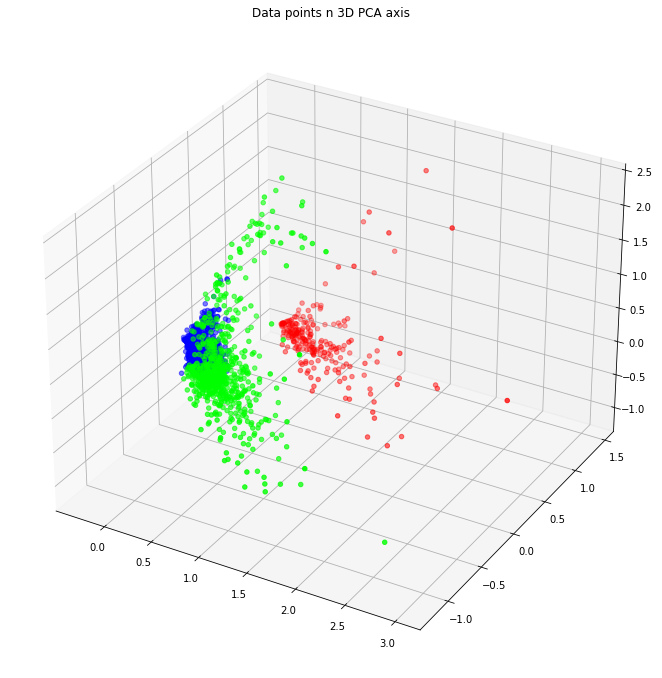

In [25]:
km = KMeans(n_clusters = 3)
plt.rcParams['figure.figsize'] = (16, 9)
clusters =km.fit_predict(pca_fit)
cmhot = plt.get_cmap('brg')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_fit[0], pca_fit[2], pca_fit[1], c = clusters, cmap = cmhot)
plt.title('Data points n 3D PCA axis')
plt.show()


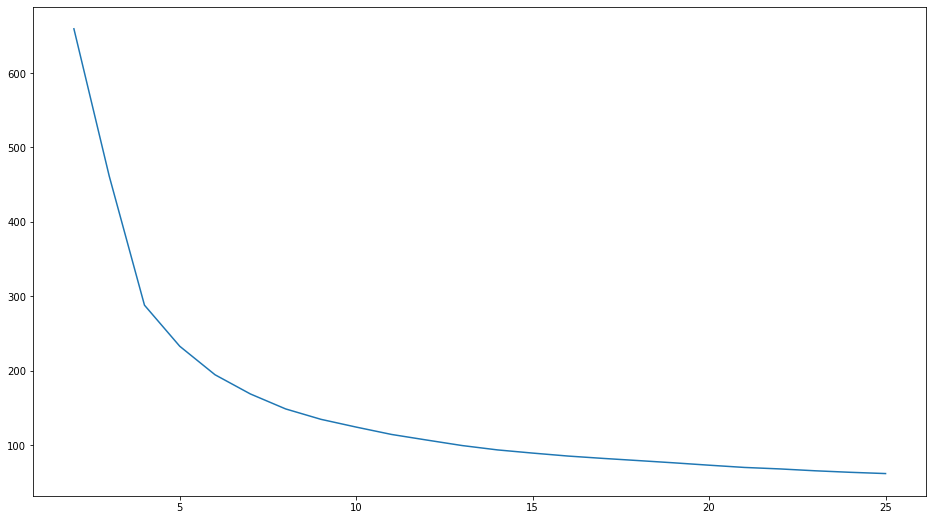

In [26]:
tss = []
for i in range(2, 26):
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(pca_fit)
    tss.append(km.inertia_)
plt.plot(range(2, 26), tss, '-')
plt.show()


For n_clusters = 3 The average silhouette_score is : 0.6712662813456601
For n_clusters = 4 The average silhouette_score is : 0.66864276819225
For n_clusters = 5 The average silhouette_score is : 0.5863203293397985
For n_clusters = 6 The average silhouette_score is : 0.608852307989045
For n_clusters = 7 The average silhouette_score is : 0.6045270634813458
For n_clusters = 8 The average silhouette_score is : 0.5340435714714402


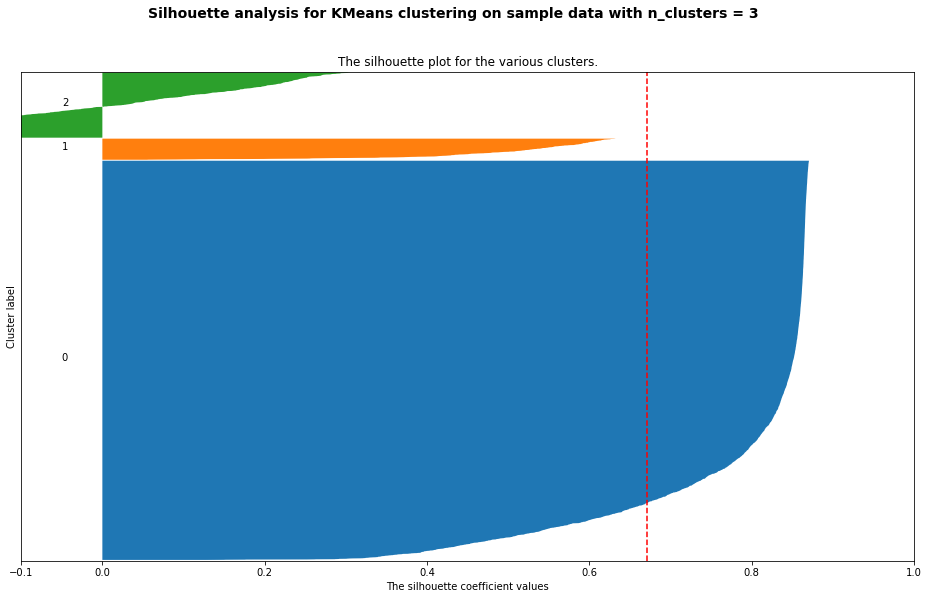

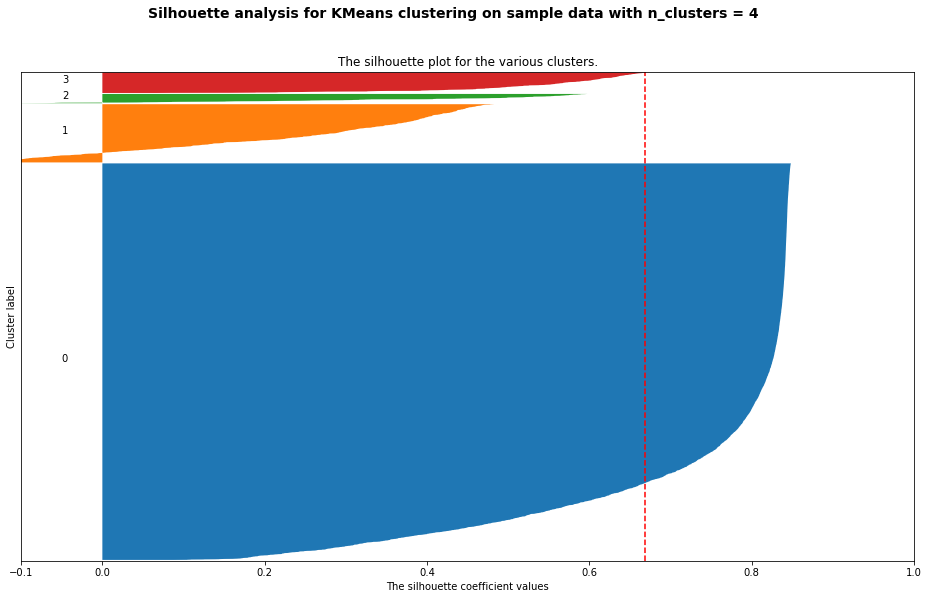

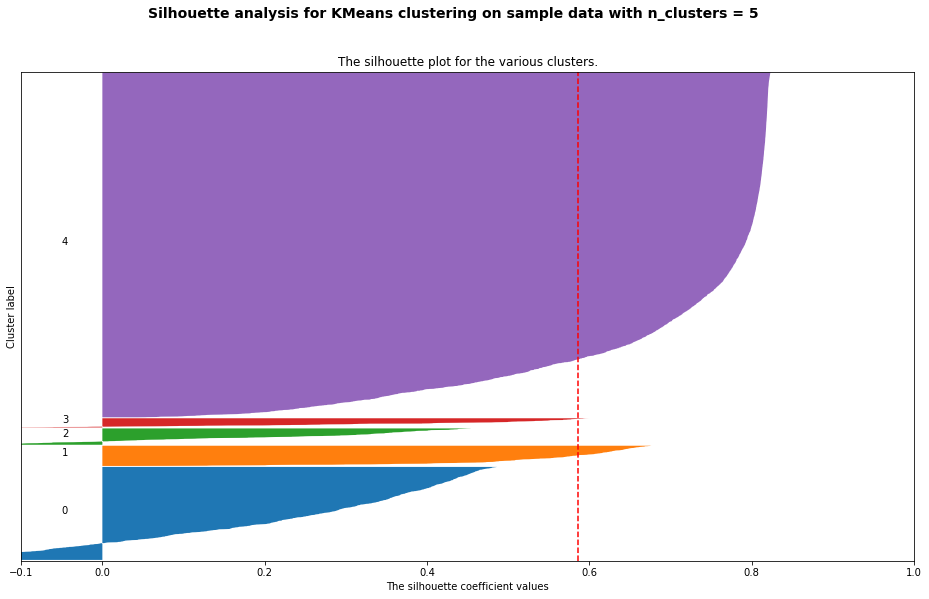

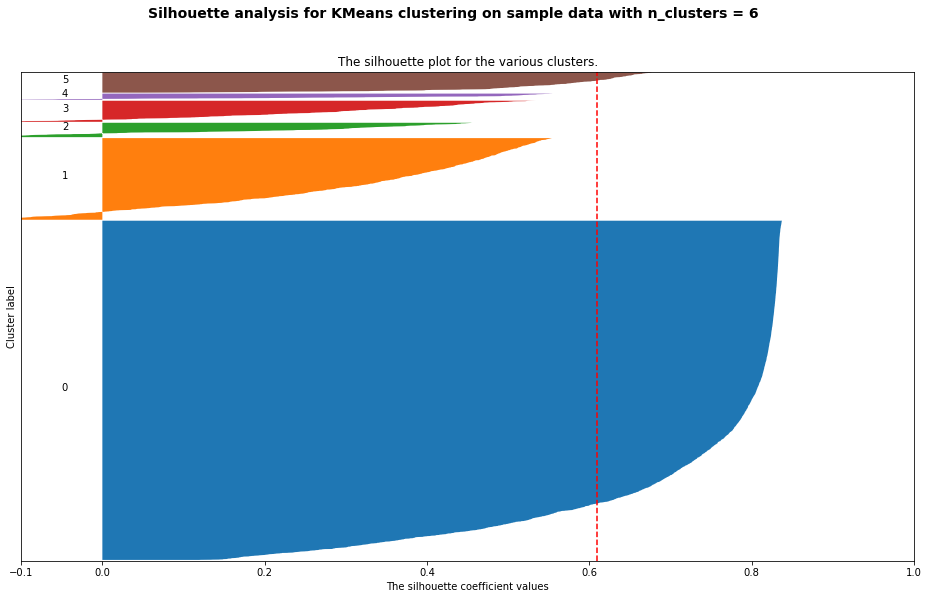

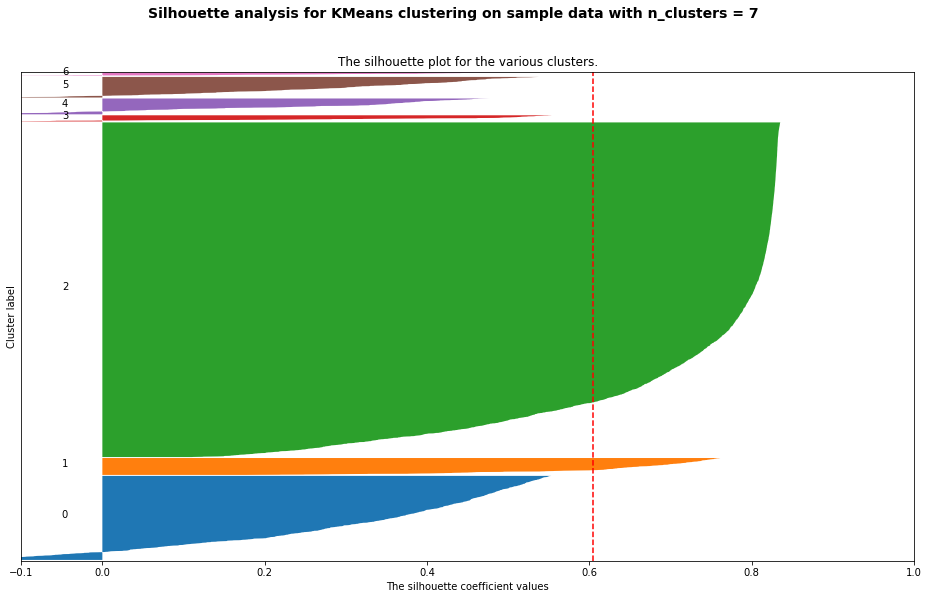

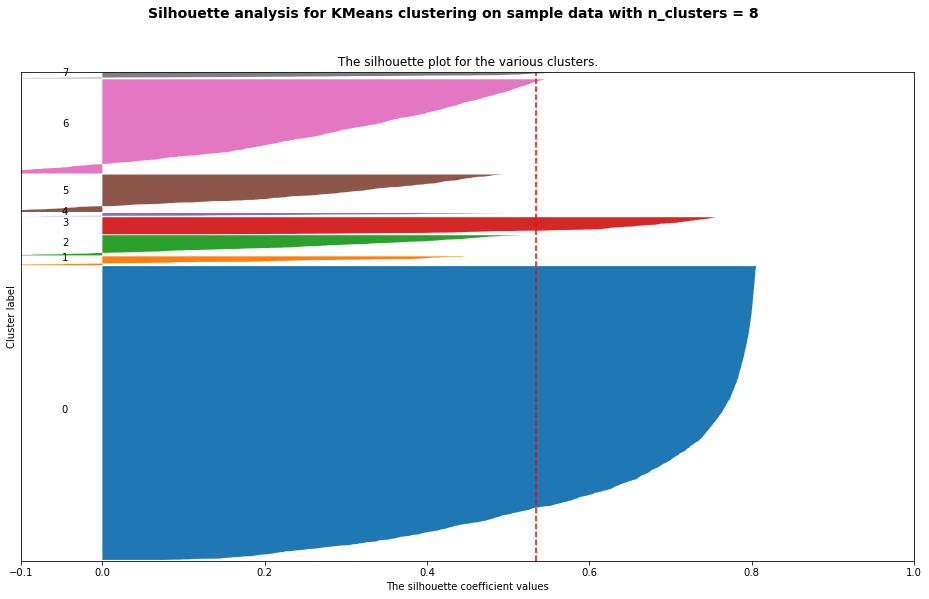

In [27]:
for n in [3,4,5,6,7,8]:
    ax1 = plt.figure().gca()
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_fit) + (n + 1) * 10])
    km = KMeans(n_clusters=n,random_state=0)
    clusters = km.fit_predict(pca_fit)
    silhouette_avg = silhouette_score(pca_fit, clusters)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_values = silhouette_samples(pca_fit, clusters)
    y_start = 10
    for i in range(n): 
        ith_cluster = np.sort(silhouette_values[clusters==i])
        cluster_size = ith_cluster.shape[0]
        y_end = y_start + cluster_size 
        ax1.fill_betweenx(np.arange(y_start, y_end),
                          0, ith_cluster)
        ax1.text(-0.05, y_start + 0.5 * cluster_size, str(i))
        y_start = y_end + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n),
                 fontsize=14, fontweight='bold')
plt.show()


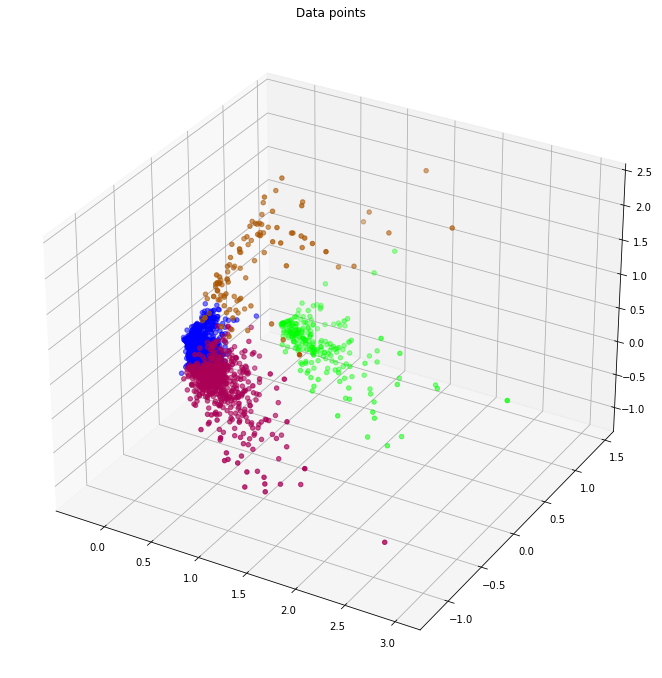

In [28]:

kmeans_4 = KMeans(n_clusters = 4, random_state = 0).fit(pca_fit)
df['cluster'] = kmeans_4.labels_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_fit[0], pca_fit[2], pca_fit[1], c = df['cluster'], cmap = cmhot)
plt.title('Data points')
plt.show()